# Problem statement and analytical solution

In our work or adult life, we sometimes struggle to fix a date with the parties which which we would like to meet, so one day, on a train commute, I wondered: What's the math behind this and how does it scale?

E.g. how many suggestions do you need to make so that it is very likely(TM) that at least one of these will be accepted? Or how bad is it to add one more party to the mix, i.e. at which point do things start to break down and become unwieldy (a very subjective metric, admittedly)?

Let's establish some nomenclatura and a proper problem description first:

- You are trying to find a date with $k$ independent parties, where "party" means a person or group of persons sharing the same preferences for a given date. I.e. a party is indivisible and shows up either full or not at all. In most cases, this means one person, but we all know these couples which only come together. Or think of a group of managers of a company you want to contact ... they will all show up or none, so they are one party.
- We completely ignore parties which always have time or will make time for any suggestion. Those are irrelevant to our problem. Only the parties which have a chance of not accepting matter here, as only those can complicate the process. That means finding a date for a school excursion is not a problem at all, despite 35 potential parties being involved: It will be set and all follow, easy problem, in effect 0 parties present.
- For these $k$ parties, you will supply $n$ suggestions, out of which you hope that at least one will get accepted.
- Each party's probability to accept an invite for a given day $j$ is $p_{yes, i}^j$.
- The probability of a given day $j$ to have all parties approve is $p_{yes}^j$.
- Thus $p_yes$ is the chance that at least one of the suggestions you made will be accepted.

Some elementary math then gives us

$$p_{yes}^j = \prod_i^k p_{yes, i}^j$$

as we need all parties to agree to a given day, so it is the product of all probabilities to agree.

Which then gives us the the probability of at least one day being accepted by calculating the probability that all are rejected and taking the inverse of that:

$$p_{yes} = 1 - \prod_j^n 1 - p_{yes}^j$$

# A simplification

The above requires you to know each party's chance to accept a scheduled date or not, and obviously you don't have that. But for our questions, you don't need that, as we want to get an idea about thresholds and break points, so let's make a simplification: Let's assume all parties share the same $p_{yes,i}^j = p$ across all days. Then the equation becomes rather simple:
$$p_{yes} = 1 - (1 - p^k)^n$$

To give us an idea, let's see a plot for $p = 0.5$, so everyone is likely to accept a given date with a 50% chance.

In [1]:
import pandas as pd

p = 0.5

dat = {
    'k': [],
    'n': [],
    'pyes': [],
}

for k in range(1, 6):
    for n in range(1, 11):
        dat['k'].append(k)
        dat['n'].append(n)
        dat['pyes'].append(1 - (1 - p**k)**n)

dat = pd.DataFrame(dat)

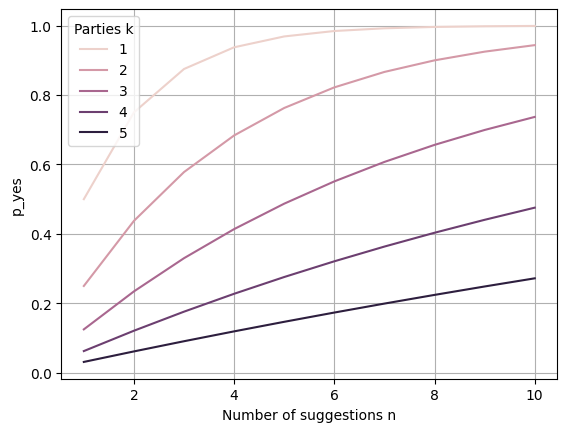

In [2]:
import seaborn as sns

ax = sns.lineplot(data=dat, x='n', y='pyes', hue='k')
ax.grid(True)
ax.set_xlabel('Number of suggestions n')
ax.set_ylabel('p_yes')
ax.legend().set_title('Parties k')

We can clearly see that increasing parties complicates matters a LOT. If only one party is uncertain to accept a date, then making three suggestions already gets you to a decent spot, but with five parties involved, no number of dates will get you there.

This means several things:
1. Adding options is always necessary. Never go with one suggestion only.
1. If you are a group and think about adding a party, think twice, it can really mess you up.
1. Problems with many groups involved will potentially never find a suitable date.
1. If you are leading a life which already has several parties you have to coordinate, then joining a new space with other parties will make things exponentially more difficult.

Case in point: I tried to organise a meeting between three companies, each having around three managers on a different schedule. It was not possible to find a single day in the span of three months.

# How many dates do I need to suggest?
Let's assume you want to have a certain probability of finding a date with your suggestions and let's call that probability $\sigma$, then you want 
$$p_{yes} \ge \sigma$$
which with some elementary math results in
$$n_{min} \ge \frac{ln(1 - \sigma)}{ln(1 - p^k)}$$
Let's have a look ...

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def min_number_suggestions(k, sigma, p):
    return np.ceil(np.log(1 - sigma) / np.log(1 - p**k)).astype(int)

sigma = 0.9
p = 0.5
k_array = [int(k) for k in range(1, 6)]  # Array to plot over

print(f"For {sigma=}:")
pd.DataFrame(
    {
        'k': k_array, 
        'n_min': [min_number_suggestions(k, sigma, p) for k in k_array],
    }
)

For sigma=0.9:


,k,n_min
0,1,4
1,2,9
2,3,18
3,4,36
4,5,73


Now that's ugly! With only one uncertain party, you already need four suggestions, to reliably find a date you will already need four suggestions. But if you want to coordinate five different parties, you need more than 70!
(Btw, you can play around with the threshold, but even if you lower it to 0.7, you only half the amount of suggestions needed. Lowering your standards does not get you a lot. Just like in real life.

# What is the added probability from adding suggestions or parties?
Now that's the part which becomes less easy to grasp, but I wanted to have a look at this to double-check and because it would look fancy, I guess.

So what we are looking for here are the derivatives, which tell us what adding one suggestion or one party would do to our overall probability. As our simplified function is rather nicely shaped we can calculate the derivates directly (again, high school math, mostly):

$$\partial_n p_{yes} = \partial_n 1 - (1 - p^k)^n = -ln(1 - p^k) (1 - p^k)^n$$

$$\partial_k p_{yes} = \partial_k 1 - (1 - p^k)^n = n (1 - p^k)^{n -1} ln(p) p^k$$

Since the $ln$-Terms are negative as the arguments are below 1, the first derivative is always positive and the second is always negative. That is to be expected, as the first derivate means adding suggestions and adding suggestions always increases the chance to find a date. Vice versa for the second derivative.

But let's have a look at the graph ...

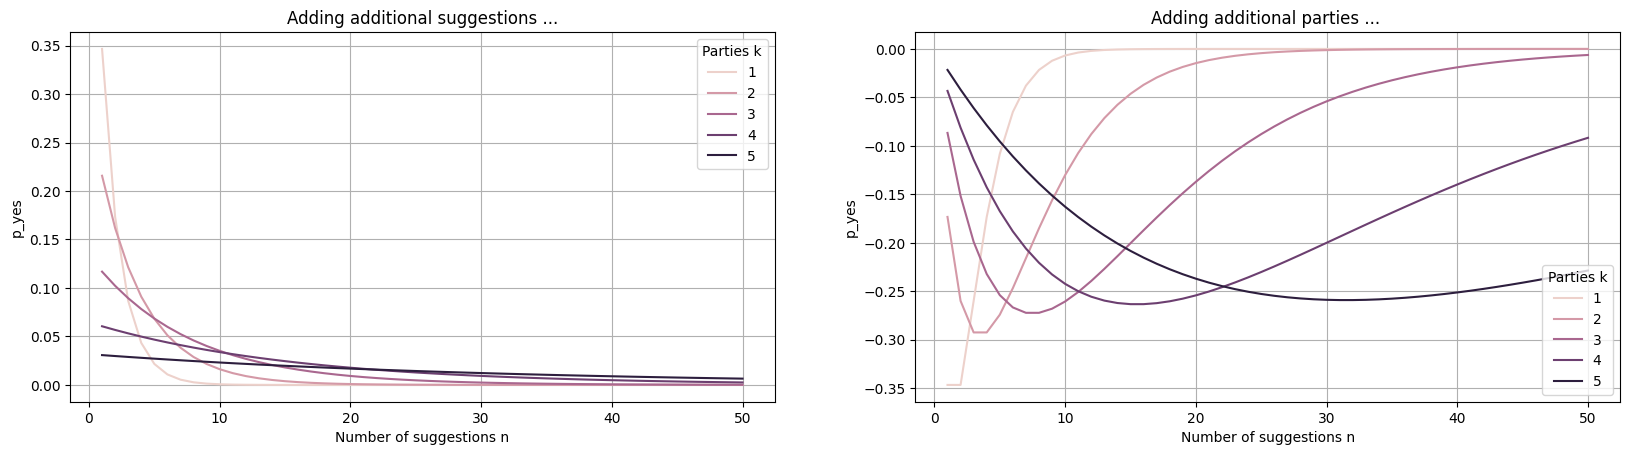

In [4]:
p = 0.5

dat = {
    'k': [],
    'n': [],
    'dpyes_dn': [],
    'dpyes_dk': [],
}

def dpyes_dn(p, k, n):
    return -np.log(1 - p ** k) * ((1 - p**k)**n)

def dpyes_dk(p, k, n):
    return n * ((1 - p**k) ** (n - 1)) * np.log(p) * (p ** k)

for k in range(1, 6):
    for n in range(1, 51):
        dat['k'].append(k)
        dat['n'].append(n)
        dat['dpyes_dn'].append(dpyes_dn(p, k, n))
        dat['dpyes_dk'].append(dpyes_dk(p, k, n))

dat = pd.DataFrame(dat)

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(20)

ax = sns.lineplot(data=dat, x='n', y='dpyes_dn', hue='k', ax=axes[0])
ax.grid(True)
ax.set_title('Adding additional suggestions ...')
ax.set_xlabel('Number of suggestions n')
ax.set_ylabel('p_yes')
ax.legend().set_title('Parties k')

ax = sns.lineplot(data=dat, x='n', y='dpyes_dk', hue='k', ax=axes[1])
ax.grid(True)
ax.set_title('Adding additional parties ... ')
ax.set_xlabel('Number of suggestions n')
ax.set_ylabel('p_yes')
ax.legend().set_title('Parties k')

We can see a few things here:

1. Adding a new suggestion has decaying marginal use, the more suggestions are already out there. No surprise.
2. Adding a new suggestion initially helps more when you have a low number of parties. Those make sense: You need fewer suggestions, so each suggestion has to add more, if you have a lower number of parties, and vice versa.
3. Adding a party always hurts you, but there is a trough where it hurts you most. Warning: This does not mean that outside of the trough, it is better. It just means: If you have lots of parties and a low number of suggestions, you are fucked anyway, so can't be fucked much harder. You will take the highest hit if you are currently sitting in the 60-80% range of p_yes and then add a party.

# A complication: Limited selection

Assume you had the $p_{yes, i}^j$, could you then calculate the optimal set of days to suggest so that it maximises your chance of approval, given you can only suggest a finite amout of dates?

Yes, surely, and the problem is actually trivial: You just calculate all $p_{yes}^j$  for all the dates for which you have data, sort them and suggest the days with the highest probability.

# A complication: Who not to invite
Assume you had the $p_{yes, i}^j$, could you then find out which party not to invite to maximise your chance of getting an approval?

Sure, though it is less elegant, as you would calculate the $p_{yes}$ while omitting the party and would compare it to the $p_{yes}$ with all parties considered and see where you would get the highest uplift.

Can't I just look at the party's preference and eliminate the one with the lowest overall probability to say yes? No, you can't, as it could be that this party has a high chance associated with dates likely to be chosen and low chances with dates which are will not be chosen anyway. It could be that the main blocker for finding a date is a party which has high chances for low-likelihood dates and a very low chance on the probable winner.

Consider for example, in which we list the individual probabilities. Party B has the lowest overall probability with 0.4.
Please consider the last line which gives $p_{yes}$ when leaving out the respective column!

| Day | A | B | C |
| --- | --- | --- | --- |
| 1 | 0.5 | 0.3 | 0.5  |
| 2 | 0.3 | 0.6 | 0.8  |
| 3 | 0.5 | 0.3 | 0.5  |
| Avg | 0.43 | 0.4 | 0.6 |
| $p_{yes}$ when<br>left out | 66% | 58% | 40% |

Despite B having a lower average probability, the overall results benefits the most when A is left out, with a $p_{yes}$ of 66%! Yes, non-linear combination are unintuitive.

# Summary
How does the above help you? Not much, but you can get a few heuristics from that:

1. Never organise something with lots of people where everyone has to be there. If you absolutely must, then suggest and ungodly amount of possible dates.
2. Try to fix certain time slots in advance if possible. Try to avoid dynamic scheduling.
3. Learn to love people who are flexible or have no complications. Their dull lifes make yours easier.
4. If you have troubles finding a date and then think about adding another party to the mix, don't. You will very likely not be able to find a date anymore.